## Packages

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import os

import collections
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Lectura de les dades

In [6]:
print(tf. __version__)

2.6.0


In [7]:
os.getcwd()

'C:\\Users\\aidaf\\TFG'

In [8]:
data_dir = os.path.join(os.getcwd() + "\\lung_colon_image_set")
data_dir

'C:\\Users\\aidaf\\TFG\\lung_colon_image_set'

In [9]:
classes = os. listdir(data_dir)
print(classes)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [10]:
dades_Y = np.load('labels_reduced.npy')
dades_X = np.load('images_reduced.npy')

## Descripció de les dades

Dimensió: 

In [11]:
print('Dimensions de les dades : ', dades_X.shape, dades_Y.shape)

Dimensions de les dades :  (4500, 120, 120, 3) (4500,)


Nombre de classes i etiquetes: 

In [12]:
n_classes = len(classes)
print('Nombre de classes : ', n_classes)
print('Etiquetes de les classes : ', classes)

Nombre de classes :  5
Etiquetes de les classes :  ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Distribució de les classes: 

In [13]:
ocurrences=collections.Counter(dades_Y)

print("Distribució de les classes : ",ocurrences)

Distribució de les classes :  Counter({0: 900, 3: 900, 1: 900, 4: 900, 2: 900})


([<matplotlib.patches.Wedge at 0x208620f60d0>,
 [Text(0.8899186877588753, 0.6465637858537406, 'colon_aca'),
  Text(-0.3399187231970732, 1.046162158377023, 'colon_n'),
  Text(-1.0999999999999988, -5.149471622296949e-08, 'lung_aca'),
  Text(-0.33991862524830174, -1.0461621902025062, 'lung_n'),
  Text(0.8899187482945414, -0.6465637025335375, 'lung_scc')])

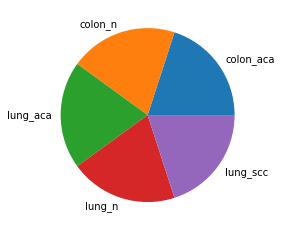

In [10]:
plt.pie(list(ocurrences.values()), labels=classes)

Visualització d'un exemple de cada categoria: 

In [11]:
def print_classes(clas):
    for cat in clas:
        files=os.listdir(os.path.join(os.getcwd()+'\\lung_colon_image_set\\'+ cat))
        d=random.choice(files)
        img=(os.path.join(os.getcwd()+'\\lung_colon_image_set\\'+ cat)+"\\"+d)
        
        plt.figure()
        plt.imshow(load_img(img))
        plt.title("Ground Truth : {}".format(cat))

Possibles confusions entre categories a simple vista:

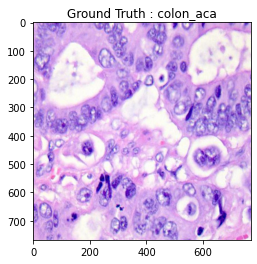

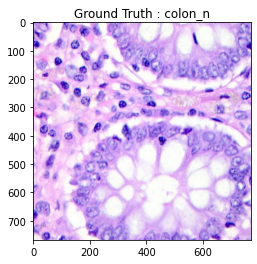

In [12]:
category=["colon_aca","colon_n"] # seleccionar les categories que es puguin confondre entre si

print_classes(category)

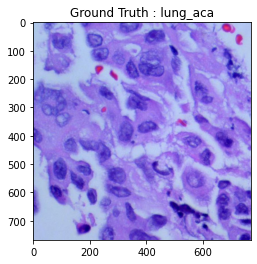

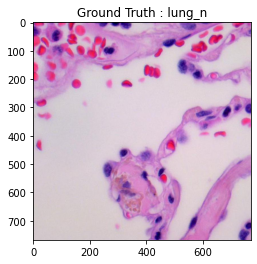

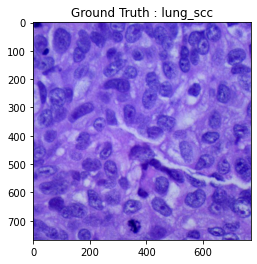

In [13]:
category=["lung_aca","lung_n","lung_scc"] # seleccionar les categories que es puguin confondre entre si

print_classes(category)

## Pre-processing

One-hot:

In [14]:
dades_Y_one_hot = np.array(pd.get_dummies(dades_Y))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')
dades_Y_one_hot.shape

(4500, 5)

In [15]:
dades_X.shape

(4500, 120, 120, 3)

Split validation-train:

In [16]:
train_X,valid_X,train_label,valid_label = train_test_split(dades_X, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot)

In [17]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((4050, 120, 120, 3), (450, 120, 120, 3), (4050, 5), (450, 5))

Mostrem que efectivament la mostra de validació està estratificada per classes:

In [18]:
ocurrences2=collections.Counter(np.argmax(np.round(valid_label),axis=1))

print("Distribució de les classes : ",ocurrences2)

Distribució de les classes :  Counter({4: 90, 2: 90, 1: 90, 0: 90, 3: 90})


## Model

In [19]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X.shape[1],dades_X.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 60, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [22]:
# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 64

# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/20
64/64 [==============================] - 150s 2s/step - loss: 1.1727 - accuracy: 0.5032 - val_loss: 0.6511 - val_accuracy: 0.6556
Epoch 2/20
64/64 [==============================] - 130s 2s/step - loss: 0.6339 - accuracy: 0.6810 - val_loss: 0.5504 - val_accuracy: 0.7244
Epoch 3/20
64/64 [==============================] - 132s 2s/step - loss: 0.5394 - accuracy: 0.7511 - val_loss: 0.4387 - val_accuracy: 0.8244
Epoch 4/20
64/64 [==============================] - 133s 2s/step - loss: 0.4326 - accuracy: 0.8165 - val_loss: 0.4866 - val_accuracy: 0.7644
Epoch 5/20
64/64 [==============================] - 133s 2s/step - loss: 0.3225 - accuracy: 0.8644 - val_loss: 0.4679 - val_accuracy: 0.8000
Epoch 6/20
64/64 [==============================] - 132s 2s/step - loss: 0.2961 - accuracy: 0.8862 - val_loss: 0.3397 - val_accuracy: 0.8533
Epoch 7/20
64/64 [==============================] - 131s 2s/step - loss: 0.2318 - accuracy: 0.9096 - val_loss: 0.2516 - val_accuracy: 0.8978
Epoch 8/20
64

In [23]:
model.save("def_model.h5")

In [18]:
def_model = keras.models.load_model('def_model.h5')
test_eval = def_model.evaluate(valid_X,valid_label, verbose=0)

In [25]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.31248939037323
Test accuracy: 0.9399999976158142


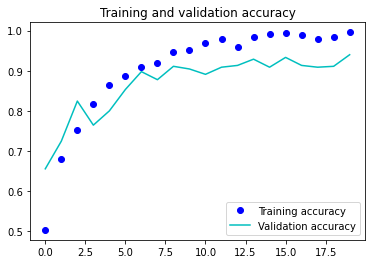

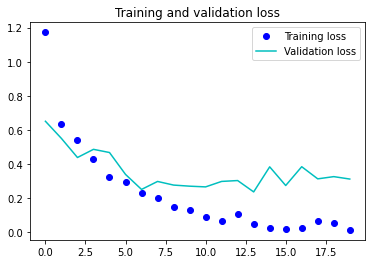

In [26]:
accuracy = H.history['accuracy']
val_accuracy = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'c', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [27]:
predicted_classes = def_model.predict(valid_X)

In [28]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

In [29]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.97      0.97      0.97        90
     colon_n       0.97      0.97      0.97        90
    lung_aca       0.90      0.87      0.88        90
      lung_n       0.99      0.98      0.98        90
    lung_scc       0.88      0.92      0.90        90

    accuracy                           0.94       450
   macro avg       0.94      0.94      0.94       450
weighted avg       0.94      0.94      0.94       450



In [30]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

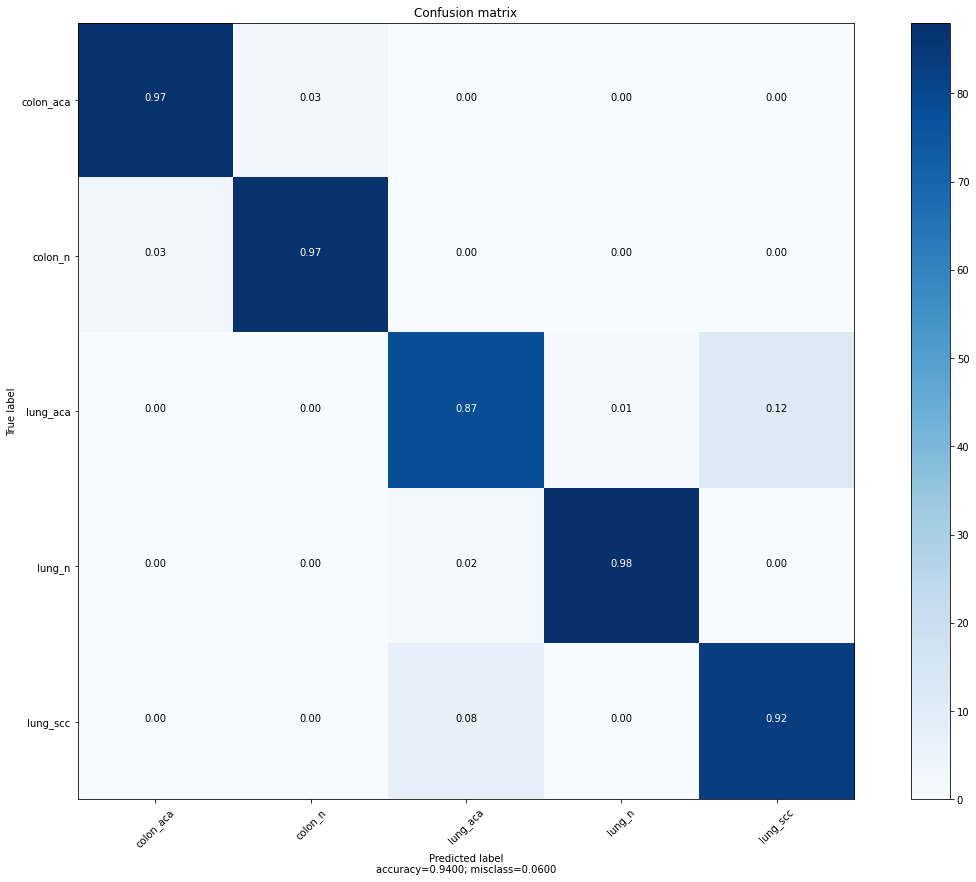

In [31]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

clean_Y = np.load('labels_reduced_clean.npy')
clean_X = np.load('images_reduced_clean.npy')

clean_X.shape, clean_Y.shape

prediction = def_model.predict(clean_X)
pred_labs_defs = []

for i in range(len(prediction)):
    pred_labs_defs.append(np.argmax(prediction[i]))

## Cross-validation

In [32]:
# Merge inputs and targets
inputs = np.concatenate((train_X, valid_X), axis=0)
targets = np.concatenate((train_label, valid_label), axis=0)

acc_per_fold = []
loss_per_fold = []

FOLDS = 5
EPOCHS = 20
BS = 64

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True)

# Define Data Augmentation

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, np.argmax(np.round(targets),axis=1)):

    # Define the model architecture
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(dades_X.shape[1],dades_X.shape[2],3)))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))
    
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
64/64 [==============================] - 131s 2s/step - loss: 0.8795 - accuracy: 0.5743 - val_loss: 0.5161 - val_accuracy: 0.7822
Epoch 2/20
64/64 [==============================] - 130s 2s/step - loss: 0.5108 - accuracy: 0.7721 - val_loss: 0.3896 - val_accuracy: 0.8311
Epoch 3/20
64/64 [==============================] - 130s 2s/step - loss: 0.4102 - accuracy: 0.8215 - val_loss: 0.3107 - val_accuracy: 0.8800
Epoch 4/20
64/64 [==============================] - 131s 2s/step - loss: 0.3395 - accuracy: 0.8578 - val_loss: 0.3031 - val_accuracy: 0.8778
Epoch 5/20
64/64 [==============================] - 133s 2s/step - loss: 0.2553 - accuracy: 0.9035 - val_loss: 0.2810 - val_accuracy: 0.8956
Epoch 6/20
64/64 [==============================] - 132s 2s/step - loss: 0.2000 - accuracy: 0.9277 - val_loss: 0.2425 - val_accuracy: 0.9000
Epoch 7/20
64/64 [==============================] - 132s 

Epoch 16/20
64/64 [==============================] - 132s 2s/step - loss: 0.0323 - accuracy: 0.9891 - val_loss: 0.2945 - val_accuracy: 0.9311
Epoch 17/20
64/64 [==============================] - 131s 2s/step - loss: 0.0219 - accuracy: 0.9943 - val_loss: 0.2917 - val_accuracy: 0.9267
Epoch 18/20
64/64 [==============================] - 131s 2s/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.2963 - val_accuracy: 0.9400
Epoch 19/20
64/64 [==============================] - 130s 2s/step - loss: 0.0094 - accuracy: 0.9980 - val_loss: 0.3379 - val_accuracy: 0.9311
Epoch 20/20
64/64 [==============================] - 132s 2s/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.3787 - val_accuracy: 0.9311
Score for fold 3: loss of 0.028718460351228714; accuracy of 99.11110997200012%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/20
64/64 [==============================] - 134s 2s/step - loss: 1.0766 - accuracy: 0.5180 - val_loss: 0.7

In [33]:
acc_per_fold

[98.00000190734863,
 97.55555391311646,
 99.11110997200012,
 91.88888669013977,
 99.6666669845581]

In [34]:
print("Estimació accuracy dels kfolds:",sum(acc_per_fold)/len(acc_per_fold))

Estimació accuracy dels kfolds: 97.24444389343262
